# Iris Detection Model

## 0. Install Dependencies and Import

In [13]:
!pip install tensorflow opencv-python matplotlib

In [14]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import time
import uuid
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1. Load Data

### 1.1 Load Images

In [16]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [17]:
maindir = r'/content/drive/MyDrive/Machine Learning/Iris Detection Model'
train_images = tf.data.Dataset.list_files(os.path.join(maindir,r'aug_data/train/images/*.jpg'), shuffle=False)\
                            .map(load_image)\
                            .map(lambda x: tf.image.resize(x, (250, 250)))\
                            .map(lambda x: x/255)

test_images = tf.data.Dataset.list_files(os.path.join(maindir,r'aug_data/test/images/*.jpg'), shuffle=False)\
                            .map(load_image)\
                            .map(lambda x: tf.image.resize(x, (250, 250)))\
                            .map(lambda x: x/255)

val_images = tf.data.Dataset.list_files(os.path.join(maindir,r'aug_data/val/images/*.jpg'), shuffle=False)\
                            .map(load_image)\
                            .map(lambda x: tf.image.resize(x, (250, 250)))\
                            .map(lambda x: x/255)

### 1.2 Load Labels

In [18]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['keypoints']]

In [19]:
train_labels = tf.data.Dataset.list_files(os.path.join(maindir,r'aug_data/train/labels/*.json'), shuffle=False)\
                            .map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

test_labels = tf.data.Dataset.list_files(os.path.join(maindir,r'aug_data/test/labels/*.json'), shuffle=False)\
                            .map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

val_labels = tf.data.Dataset.list_files(os.path.join(maindir,r'aug_data/val/labels/*.json'), shuffle=False)\
                            .map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 1.3 Combine Labels and Images

In [20]:
train = tf.data.Dataset.zip((train_images, train_labels)).shuffle(5000).batch(1).prefetch(1)
test = tf.data.Dataset.zip((test_images, test_labels)).shuffle(5000).batch(1).prefetch(1)
val = tf.data.Dataset.zip((val_images, val_labels)).shuffle(5000).batch(1).prefetch(1)

### 1.4 View Samples

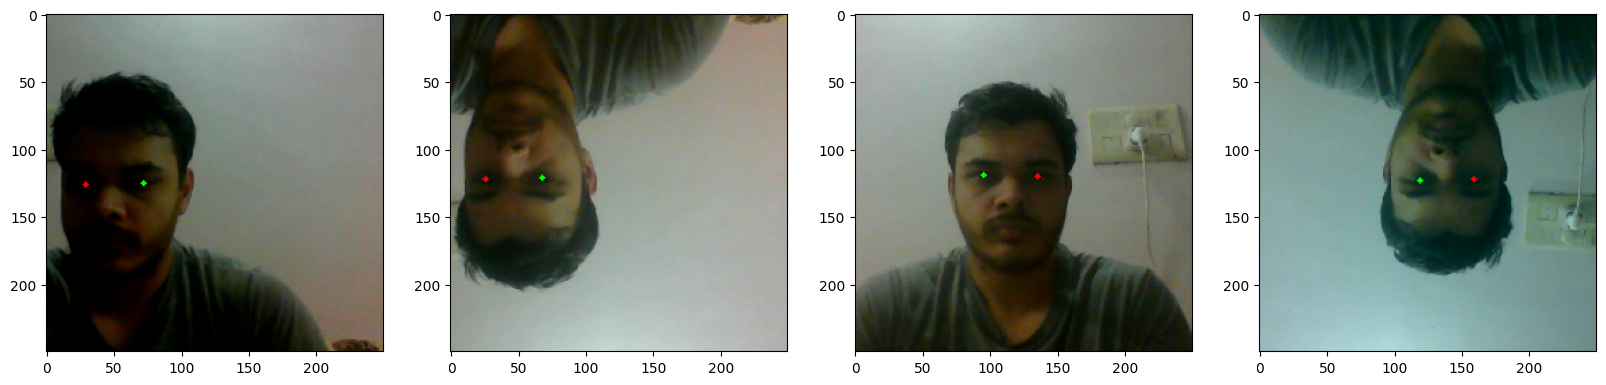

In [ ]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    #Red - Right Eye
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    #250,250 is the dimension of image
    #Green - Left Eye
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    ax[idx].imshow(sample_image)

## 2. Build Model

### 2.1 Create Neural Network

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications  import ResNet152V2

In [22]:
model = Sequential([
    Input(shape=(250,250,3)),
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),#increasing the stride by 2
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4,  2, 2),
    Reshape((4,))
])
#Ultimately, using the input shape and passing through the ResNet, we need to get 4 final values: xy xy from left and right eyes

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

### 2.2 Setup Losses and Optimizer

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

In [24]:
model.compile(optimizer,loss)

### 2.3 Sense Check Predictions

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(16, 250, 250, 3)

In [ ]:
coordinates = model.predict(X)

1/1 [==============================] - 0s 44ms/step


In [ ]:
coordinates

array([[ 0.08010967,  0.37748727, -0.6982925 ,  0.97771305],
       [-0.16908851,  0.09734999, -0.50685596,  0.7614974 ],
       [ 0.26110354,  1.5916102 , -1.7020053 ,  1.7065847 ],
       [-0.3605692 ,  0.9142327 , -0.33662996,  2.1885962 ],
       [ 0.21448489,  0.9867818 , -0.03003306,  0.588281  ],
       [-0.03341866, -0.3185406 , -0.94570833,  2.220732  ],
       [ 0.17198808,  0.42282835, -0.5558161 ,  0.42828363],
       [-1.1867058 ,  0.5183523 ,  0.2408039 ,  0.95354456],
       [-0.44103733,  0.25688133, -1.2465572 ,  0.76289773],
       [-0.01118816,  1.1545886 , -1.2115694 ,  1.4971348 ],
       [ 0.12704511,  0.3588578 , -0.05911725,  0.93424296],
       [-0.42053446,  0.4831773 , -1.6245677 ,  2.359177  ],
       [ 0.3090103 ,  0.12063126, -0.24816753,  0.38418853],
       [-0.13927832,  0.4568248 , -0.33711848,  0.97621405],
       [-0.28902593,  0.7731112 , -1.6576439 ,  1.7430303 ],
       [-0.2106425 , -0.11591055,  0.18937238,  2.0740347 ]],
      dtype=float32)

### 2.4 Train the Model

In [ ]:
hist = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5


## 3. Review Performance

### 3.1 View Loss Plots

In [ ]:
hist.history

In [ ]:
plt.plot(hist.histor['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 3.2 Make Predictions on Test

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    #Red - Right Eye
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    #250,250 is the dimension of image
    #Green - Left Eye
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    ax[idx].imshow(sample_image)

### 3.3 Save the Model

In [ ]:
from tensorflow.keras.models import load_model
model.save(r'/content/drive/MyDrive/Machine Learning/Iris Detection Model/irisdetection.h5')

In [ ]:
# model = load_model('/content/drive/MyDrive/Machine Learning/Iris Detection Model/irisdetection.h5')

In [ ]:
# model.predict(test_sample[0])

## 4. Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()

    frame = frame[50:500, 50:500, :] #Resizing the 640x480 frame to 450x450 pixels
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))

    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]

    cv2.circle(frame, tuple(np.multiple(sample_coords[:2], [450,450]).astype(int)),2,(255,0,0),-1)
    cv2.circle(frame, tuple(np.multiple(sample_coords[2:], [450,450]).astype(int)),2,(0,255,0),-1)
    cv2.imshow('IrisTracker', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()